#### Importamos las librerías necesarias

In [1]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
import numpy as np

#### Conexión a la DB

In [2]:
#Credenciales AWS

username = "admin"
password = "pruebatecnica"
host = "technicaltest.cnvu29xw2umg.us-east-2.rds.amazonaws.com" 
port = 3306

In [3]:
#Conexión DB

db = pymysql.connect(host = host,
                     user = username,
                     password = password,
                     cursorclass = pymysql.cursors.DictCursor
)
cursor = db.cursor()

In [4]:
#Seleccionar base de datos
cursor.connection.commit()
use_db = ''' USE tweets_database'''
cursor.execute(use_db)

0

### Data Analytics

#### ¿Cuál es el tweet con mayor repercusión social?

In [5]:
sql = '''SELECT * 
FROM tweets 
ORDER BY retweets_count
DESC LIMIT 1;'''
cursor.execute(sql)
mi_tabla = cursor.fetchall()
mi_tabla

[{'id': 1614612463361695747,
  'text': 'Advanced #Cynefin, Estuarine mapping &amp; EUFG Masterclass (Madrid) https://t.co/H5ZSjbKHAr | Los interesados en la aplicación de las ciencias de la complejidad en nuestro país tendremos la oportunidad de aprender de @snowded en persona el 16/3/23 en la sede de @TheBridge_Tech https://t.co/LavCfgYIht',
  'date': datetime.datetime(2023, 1, 15, 13, 16, 23),
  'author_id': 41545659,
  'retweets_count': 51,
  'replies_count': 7,
  'likes_count': 326,
  'quotes_count': 4}]

#### ¿Cuál es el usuario que más menciona a la escuela?

In [15]:
sql = '''SELECT author_id, COUNT(*) AS count
FROM tweets 
GROUP BY author_id
ORDER BY count
DESC LIMIT 1;'''
cursor.execute(sql)
mi_tabla = cursor.fetchall()
mi_tabla

[{'author_id': 702077405045899264, 'count': 22}]

In [16]:
sql = '''SELECT author_name
FROM users
WHERE author_id = 702077405045899264'''
cursor.execute(sql)
mi_tabla = cursor.fetchall()
mi_tabla

[{'author_name': 'Fundación BBK | Obra Social'}]

#### ¿En qué mes se concentra el mayor número de tweets?

In [17]:
sql = '''SELECT MONTH(date) AS month, COUNT(*) AS num_tweets 
FROM tweets 
GROUP BY month 
ORDER BY num_tweets DESC '''
cursor.execute(sql)
mi_tabla = cursor.fetchall()
mi_tabla

[{'month': 1, 'num_tweets': 49},
 {'month': 11, 'num_tweets': 27},
 {'month': 12, 'num_tweets': 23},
 {'month': 2, 'num_tweets': 17},
 {'month': 3, 'num_tweets': 12}]

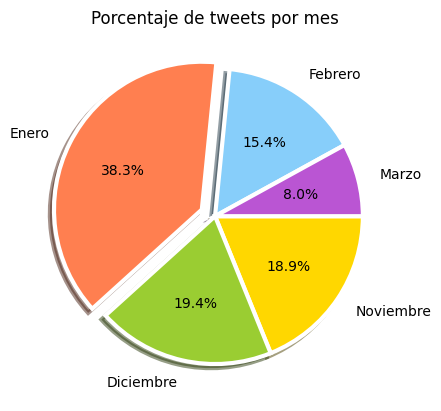

In [18]:
# datos
data = [{'month': 11, 'num_tweets': 33},
        {'month': 12, 'num_tweets': 34},
        {'month': 1, 'num_tweets': 67},
        {'month': 2, 'num_tweets': 27},
        {'month': 3, 'num_tweets': 14}]

# Crear listas separadas para el mes y el número de tweets
months = [d['month'] for d in data]
num_tweets = [d['num_tweets'] for d in data]

# Crear una lista de nombres de los meses en orden
month_names = ['Noviembre', 'Diciembre', 'Enero', 'Febrero', 'Marzo']

# Crear el gráfico de tarta
#colors = ['#fa7e1e', '#feda75', '#4f5bd5', '#962fbf', '#d62976']
colors = ['gold', 'yellowgreen', 'coral', 'lightskyblue', 'mediumorchid']
explode = (0, 0, 0.1, 0, 0)  # explode 1st slice

plt.pie(num_tweets, labels=month_names, colors=colors, startangle=0, counterclock=False, explode=explode, shadow=True, autopct='%1.1f%%', labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })

# Establecer el título
plt.title('Porcentaje de tweets por mes')

# Mostrar el gráfico
#plt.axis('equal')

plt.savefig('img/groupby_month.png')
plt.show()

#### ¿Qué palabras son más frecuentes?

In [48]:
tweets = pd.read_csv('data/tweets.csv')

In [25]:
# Función para Procesar y limpiar dataframe 

def nlp_clean(df, column, language):

    #Borramos los missing values
    df.dropna(inplace=True)
    
    # Eliminamos los duplicados
    df.drop_duplicates(inplace=True)

    #Eliminamos menciones
    df[column] = df[column].str.replace(r'\s*@\w+', '', regex=True)

    #Eliminamos signos de puntuación y pasamos a minúsculas
    signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\¿)|(\@)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")

    def signs_tweets(tweet):
        return signos.sub('', tweet.lower())

    df[column] = df[column].apply(signs_tweets)
    
    #Eliminamos los emojis
    df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

    #Eliminamos links
    def remove_links(df):
        return " ".join([' ' if ('http') in word else word for word in df.split()])
    
    df[column] = df[column].apply(remove_links)

    #Eliminamos stopwords
    stopwords_lang = stopwords.words(language)
    def remove_stopwords(df):
        return " ".join([word for word in df.split() if word not in stopwords_lang])
    
    df[column] = df[column].apply(remove_stopwords)

    #Guardamos los datos procesados
    final_df = df[[column]]
    return final_df

In [26]:
clean_df = nlp_clean(tweets, 'text', 'spanish')

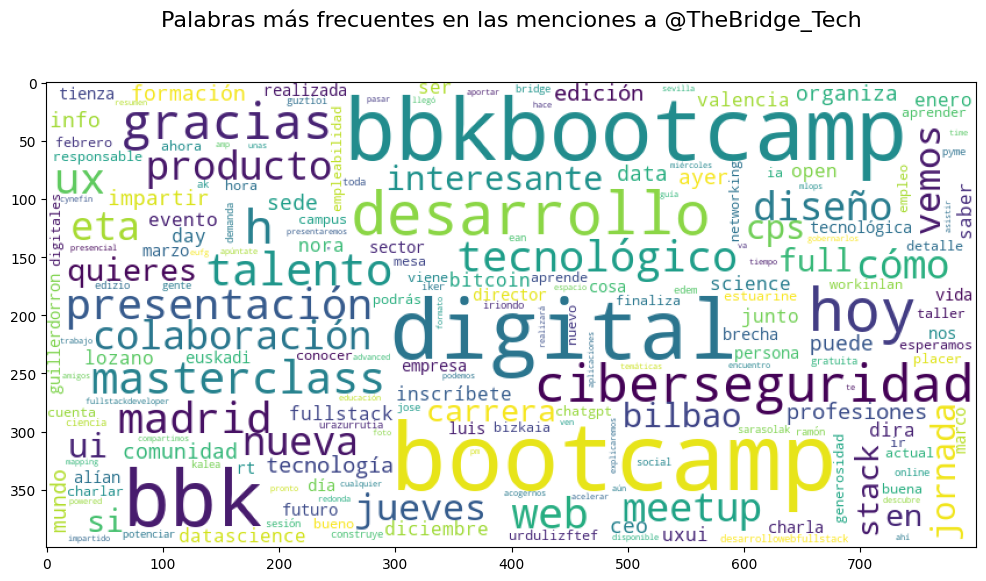

In [29]:
from wordcloud import WordCloud

#Wordcloud 
wordcloud = WordCloud(background_color='white', collocations=False,
                max_words = 200, max_font_size = 80, 
                 width=800, height=400)

plt.figure(figsize=(12, 12))
wordcloud.generate(' '.join(clean_df['text']))
plt.grid(visible=False)
plt.title('Palabras más frecuentes en las menciones a @TheBridge_Tech', fontsize=16, pad=40)
plt.imshow(wordcloud);
wordcloud.to_file('img/wordcloud.png')

#### ¿Qué tipo de correlación matemática encuentras entre las métricas públicas?

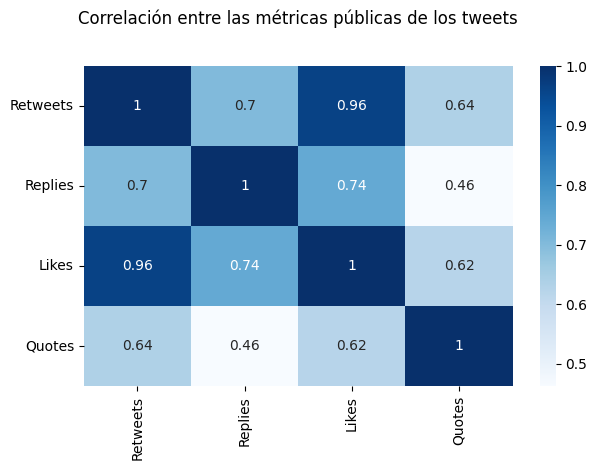

In [23]:
# Extraer las métricas públicas
metrics = tweets.loc[:,'retweets_count':'quotes_count']

# Crear el heatmap de correlación
fig, ax = plt.subplots()
sns.heatmap(metrics.corr(), annot=True, cmap='Blues', ax=ax)

# Cambiar los nombres de los xticks
ax.set_xticklabels(['Retweets', 'Replies', 'Likes', 'Quotes'])
ax.set_yticklabels(['Retweets', 'Replies', 'Likes', 'Quotes'])

# Establecer el título del gráfico
ax.set_title('Correlación entre las métricas públicas de los tweets', pad=30, loc= 'center')

fig.tight_layout()
plt.savefig('img/correlations.png')
plt.show()

#### Distribución de la longitud de los tweets

In [45]:
lengths = []
for index, i in enumerate(tweets['text']):
    lengths.append(len(i))

tweets['length'] = lengths

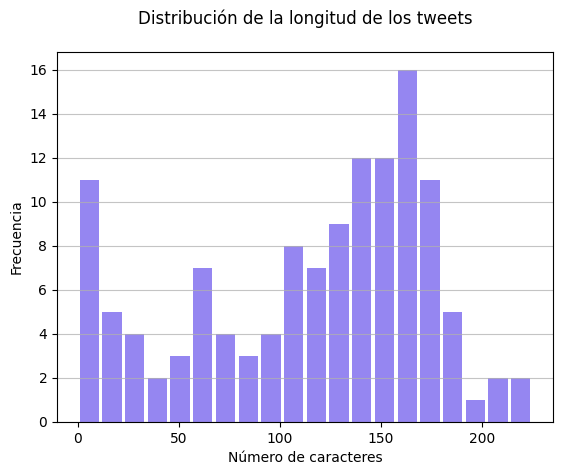

In [67]:
plt.hist(x=tweets['length'], bins=20, color='mediumslateblue',
                            alpha=0.8, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Número de caracteres')
plt.ylabel('Frecuencia')
plt.title('Distribución de la longitud de los tweets', pad=20)
plt.savefig('img/length_tweets.png')

In [167]:
db.close()